In [1]:
#export
"""Higher order functions"""
__all__ = ["Func", "polyfit", "derivative", "optimize", "inverse", "integral", "batchify"]
from typing import Callable, List
import k1lib, numpy as np, warnings, threading, time, inspect
from functools import partial
plt = k1lib.dep.plt
import k1lib.cli as cli

In [2]:
#export
Func = Callable[[float], float]
def polyfit(x:List[float], y:List[float], deg:int=6) -> Func:
    """Returns a function that approximate :math:`f(x) = y`.
Example::

    xs = [1, 2, 3]
    ys = [2, 3, 5]
    f = k1.polyfit(xs, ys, 1)

This will create a best-fit function. You can just use it as a regular,
normal function. You can even pass in :class:`numpy.ndarray`::

    # returns some float
    f(2)

    # plots fit function from 0 to 5
    xs = np.linspace(0, 5)
    plt.plot(xs, f(xs))

:param deg: degree of the polynomial of the returned function"""
    params = np.polyfit(x, y, deg)
    def _inner(_x):
        answer = np.zeros_like(_x, dtype=float)
        for expo, param in enumerate(params):
            answer += param * _x**(len(params)-expo-1)
        return answer
    return _inner

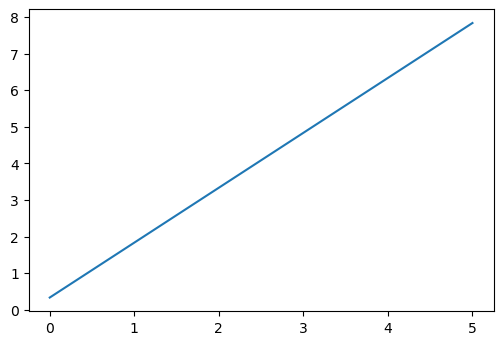

In [3]:
xs = [1, 2, 3]; ys = [2, 3, 5]
f = polyfit(xs, ys, 1)
xs = np.linspace(0, 5)
plt.plot(xs, f(xs));

In [4]:
#export
def derivative(f:Func, delta:float=1e-6) -> Func:
    """Returns the derivative of a function.
Example::

    f = lambda x: x**2
    df = k1lib.derivative(f)
    df(3) # returns roughly 6 """
    return lambda x: (f(x + delta) - f(x)) / delta

In [5]:
f = lambda x: x**2
df = derivative(f)
assert abs(df(3) - 6) < 1e-5

In [6]:
#export
def optimize(f:Func, v:float=1, threshold:float=1e-6, **kwargs) -> float:
    r"""Given :math:`f(x) = 0`, solves for x using Newton's method with initial value
`v`. Example::

    f = lambda x: x**2-2
    # returns 1.4142 (root 2)
    k1lib.optimize(f)
    # returns -1.4142 (negative root 2)
    k1lib.optimize(f, -1)

Interestingly, for some reason, result of this is more accurate than :meth:`derivative`.
"""
    if len(kwargs) > 0: f = partial(f, **kwargs)
    fD = derivative(f)
    for i in range(20):
        v = v - f(v)/fD(v)
    if abs(f(v)) > threshold: warnings.warn("k1lib.optimize not converging")
    return v

In [7]:
f = lambda x: x**2-2
assert abs(optimize(f) - 2**0.5) < 1e-6
assert abs(optimize(f, -1) + 2**0.5) < 1e-6

In [8]:
#export
def inverse(f:Func) -> Func:
    """Returns the inverse of a function.
Example::

    f = lambda x: x**2
    fInv = k1lib.inverse(f)
    # returns roughly 3
    fInv(9)

.. warning::
    The inverse function takes a long time to run, so don't use this
    where you need lots of speed. Also, as you might imagine, the
    inverse function isn't really airtight. Should work well with
    monotonic functions, but all bets are off with other functions."""
    return lambda y: optimize(lambda x: f(x) - y)

In [9]:
f = lambda x: x**2; fInv = inverse(f)
assert abs(fInv(9) - 3) < 1e-6

In [10]:
#export
def integral(f:Func, _range:k1lib.Range) -> float:
    """Integrates a function over a range.
Example::

    f = lambda x: x**2
    # returns roughly 9
    k1lib.integral(f, [0, 3])

There is also the cli :class:`~k1lib.cli.modifier.integrate`
which has a slightly different api."""
    _range = k1lib.Range(_range)
    n = 1000; xs = np.linspace(*_range, n)
    return sum([f(x)*_range.delta/n for x in xs])

In [11]:
assert abs(integral(f, [0, 3]) - 9) < 1e-2

In [1]:
#export
class Controller:
    def __init__(self):
        self.lock = threading.Lock(); self.data = {}; self.count = 0; self.event = threading.Event()
    def add(self, d):
        with self.lock: c = self.count; self.data[self.count] = d; self.count += 1; return c, self.event
    def prepare(self):
        with self.lock:
            data = {**self.data}; event = self.event
            self.data = {}; self.count = 0; self.event = threading.Event()
            return data, event
def batchify(period=0.1) -> "singleFn":
    """Transforms a function taking in batches to taking in singles,
for performance reasons.

Say you have this function that does some heavy computation::

    def f1(x, y):
        time.sleep(1)     # simulating heavy load, like loading large libraries/binaries
        return x + y      # does not take lots of time

Let's also say that a lot of time, you want to execute that function over multiple samples::

    res = [] # will be filled with [3, 7, 11]
    for x, y in [[1, 2], [3, 4], [5, 6]]:
        res.append(f1(x, y))

This would take 3 seconds to complete. But a lot of time, it might be advantageous to merge
them together and execute everything all at once::

    def f2(xs, ys):
        res = []; time.sleep(1)                       # loading large libraries/binaries only once
        for x, y in zip(xs, ys): res.append(x+y)      # run through all samples quickly
        return res

    res = f2([1, 3, 5], [2, 4, 6]) # filled with [3, 7, 11], just like before

But, may be you're in a multithreaded application and desire the original function "f1(x, y)",
instead of the batched function "f2(xs, ys)", like running an LLM (large language model) on
requests submitted by people on the internet. Each request that comes in runs on different
threads, but it's still desirable to pool together all of those requests, run through the model
once, and then split up the results to each respective request. That's where this functionality
comes in::

    @k1.batchify(0.1)     # pool up all calls every 0.1 seconds
    def f2(xs, ys):
        ...               # same as previous example
    @k1.batchify          # can also do it like this. It'll default to a period of 0.1
    def f2(xs, ys):
        ...               # same as previous example

    res = []
    t1 = threading.Thread(target=lambda: res.append(f(1, 2)))
    t2 = threading.Thread(target=lambda: res.append(f(3, 4)))
    t3 = threading.Thread(target=lambda: res.append(f(5, 6)))
    ths = [t1, t2, t3]
    for th in ths: th.start()
    for th in ths: th.join() # after this point, res will have a permutation of [3, 7, 11] (because t1, t2, t3 execution order is not known)

This will take on average 1 + 0.1 seconds (heavy load execution time + refresh rate). You can
decorate this on any Flask endpoint you want and it will just work::

    @app.get("/run/<int:nums>")
    @k1.batchify(0.3)
    def run(nums):
        time.sleep(1) # long running process
        return nums | apply("x**2") | apply(str) | deref()

Now, if you send 10 requests within a window of 0.3s, then the total running time would only be
1.3s, instead of 10s like before"""
    def wrap(batchedFn):
        data = []; con = Controller()
        def bgProcess():
            while True:
                time.sleep(period); data, event = con.prepare()
                if len(data) > 0:
                    d = data.values(); sentinel = object()
                    args = d | cli.cut(1) | cli.transpose(fill=sentinel) | cli.aS(lambda x: None if x is sentinel else x).all(2) | cli.deref()
                    kws = d | cli.cut(2) | cli.deref()
                    keys = kws | cli.op().keys().all() | cli.joinSt() | cli.aS(set) | cli.deref(); keys
                    kws = keys | cli.apply(lambda key: [key, kws | cli.apply(lambda kw: kw.get(key, None))]) | cli.toDict() | cli.deref()

                    res = list(batchedFn(*args, **kws))
                    for k, out in zip(data.keys(), res): data[k][0][0] = out
                    event.set()
        threading.Thread(target=bgProcess).start()
        def inner(*args, **kwargs):
            output = [...]; idx, event = con.add([output, args, kwargs])
            t = threading.Thread(target=lambda: event.wait()); t.start(); t.join()
            return output[0]
        inner.fullargspec = inspect.getfullargspec(batchedFn)
        return inner
    if isinstance(period, (int, float)): return wrap
    else: batchedFn = period; period = 0.1; return wrap(batchedFn)

In [2]:
@batchify
def f(d1s, e1s):
    time.sleep(1)
    return [d1s, e1s] | cli.transpose() | ~cli.apply(lambda x,y: x+y) | cli.deref()
assert (f(1, 2), f(3, 4), f(5, 6)) == (3, 7, 11)

In [1]:
!../export.py _higher

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-05 13:10:16,227	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.19:6379...
2023-12-05 13:10:16,234	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
----- exportAll
12784   0   60%   
8416    1   40%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.4.5
Uninstalling k1lib-1.4.4.5:
  Successfully uninstalled k1lib-1.4.4.5
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/